## Setup


In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import shutil
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import bcolz
from bcolz_iterator_da import BcolzArrayIterator
from bcolz_array_iterator import BcolzArrayIterator as Bit
import time
import os
import random, numbers, math
from tqdm import tqdm
import matplotlib.pyplot as plt


plt.ion()  
import pdb


Using TensorFlow backend.


In [3]:
# local_path = '/home/avinash/Documents/DeeplearningJs/resources/data'
local_path = 'smb://10.32.0.131/data/PoCs/Car_exterior_interior/'

epochs = 10
WEIGHTS_PATH = local_path+ "weights/"
data_dir = local_path +'data/equally-distributed-data/'
input_img_size = 224

In [4]:
def save_checkpoint(state):
    
    print("writing best model")
    accu = state['best_prec1']
    filename = WEIGHTS_PATH + 'no_cen_crop'+str(round(accu,4)) + '_model_best.pth.tar'
    torch.save(state, filename)

## Transfer learning with VGG 16

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.


In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(input_img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(input_img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



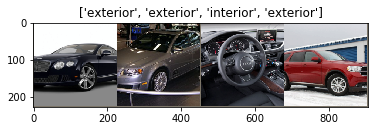

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': best_model_wts,
                    'best_prec1': best_acc,
                    'optimizer' : optimizer.state_dict(),
                })
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [10]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(40,40))

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [198]:
model_ft = models.vgg16(pretrained=True)

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.fc1 = nn.Linear(25088,4096)
        self.fc2 = nn.Linear(4096,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(x)

model_ft.classifier = classifier()

In [199]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    model_ft=model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/9
----------
train Loss: 0.0919 Acc: 0.9440
val Loss: 0.0797 Acc: 0.9955
writing best model

Epoch 1/9
----------
train Loss: 0.0859 Acc: 0.9697
val Loss: 0.0809 Acc: 0.9866

Epoch 2/9
----------
train Loss: 0.0860 Acc: 0.9662
val Loss: 0.0794 Acc: 0.9955

Epoch 3/9
----------
train Loss: 0.0848 Acc: 0.9714
val Loss: 0.0795 Acc: 0.9955

Epoch 4/9
----------
train Loss: 0.0831 Acc: 0.9813
val Loss: 0.0828 Acc: 0.9821

Epoch 5/9
----------
train Loss: 0.0831 Acc: 0.9808
val Loss: 0.0794 Acc: 0.9955

Epoch 6/9
----------
train Loss: 0.0857 Acc: 0.9697
val Loss: 0.0784 Acc: 1.0000
writing best model

Epoch 7/9
----------
train Loss: 0.0808 Acc: 0.9913
val Loss: 0.0794 Acc: 0.9955

Epoch 8/9
----------
train Loss: 0.0809 Acc: 0.9895
val Loss: 0.0792 Acc: 0.9955

Epoch 9/9
----------
train Loss: 0.0819 Acc: 0.9854
val Loss: 0.0794 Acc: 0.9955

Training complete in 5m 30s
Best val Acc: 1.000000


### Results

with input size 224 Best val Acc: 0.995536

## Transfer learning with VGG 16 with custom dataloader and data augmentation

In [5]:
# 

DATA_PATH ='/home/avinash/Documents/DeeplearningJs/resources/data/equally-distributed-data/'
WEIGHTS_PATH = "/home/avinash/Documents/DeeplearningJs/resources/data/weights"


nb_epochs = 100
batch_size = 16
img_width, img_height = 224, 224

train_data_dir= DATA_PATH + 'train'
validation_data_dir = DATA_PATH + 'val'

train_bcolz_path = DATA_PATH + 'train_bcolz'
train_label_bcolz_path = DATA_PATH + 'train_label_bcolz'
val_bcolz_path = DATA_PATH + 'val_bcolz'
val_label_bcolz_path = DATA_PATH + 'val_label_bcolz'

use_gpu = True

### Data augmentation functions

In [6]:
def randomResizedCrop(img,size):
    """Crop the given PIL Image to random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        interpolation: Default: PIL.Image.BILINEAR
    """
        
    interpolation = Image.BILINEAR
    
    for attempt in range(10):
        area = img.size[0] * img.size[1]
        target_area = random.uniform(0.08, 1.0) * area
        aspect_ratio = random.uniform(3. / 4, 4. / 3)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5:
            w, h = h, w

        if w <= img.size[0] and h <= img.size[1]:
            i = random.randint(0, img.size[1] - h)
            j = random.randint(0, img.size[0] - w)
            
            return resized_crop(img, i, j, h, w, size, interpolation)

    # Fallback
    w = min(img.size[0], img.size[1])
    i = (img.size[1] - w) // 2
    j = (img.size[0] - w) // 2
    return resized_crop(img, i, j, w, w, size, interpolation)

def resized_crop(img, i, j, h, w, size, interpolation):
    """Crop the given PIL Image and resize it to desired size.
    Notably used in RandomResizedCrop.
    Args:
        img (PIL Image): Image to be cropped.
        i: Upper pixel coordinate.
        j: Left pixel coordinate.
        h: Height of the cropped image.
        w: Width of the cropped image.
        size (sequence or int): Desired output size. Same semantics as ``scale``.
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``.
    Returns:
        PIL Image: Cropped image.
    """
    
    img = crop(img, i, j, h, w)
    img = resize(img, size, interpolation)
    return img

def resize(img, size, interpolation):
    """Resize the input PIL Image to the given size.
    Args:
        img (PIL Image): Image to be resized.
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), the output size will be matched to this. If size is an int,
            the smaller edge of the image will be matched to this number maintaing
            the aspect ratio. i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    Returns:
        PIL Image: Resized image.
    """
    if isinstance(size, int):
        w, h = img.size
        if (w <= h and w == size) or (h <= w and h == size):
            return img
        if w < h:
            ow = size
            oh = int(size * h / w)
            return img.resize((ow, oh), interpolation)
        else:
            oh = size
            ow = int(size * w / h)
            return img.resize((ow, oh), interpolation)
    else:
        return img.resize(size[::-1], interpolation)


def show_images(img):
#     from PIL import Image
    import matplotlib.pyplot as plt
#     img  = batch_x_train[i]*255

    plt.imshow(img.astype(np.uint8))
    plt.show()


def crop(img, i, j, h, w):
    """Crop the given PIL Image.
    Args:
        img (PIL Image): Image to be cropped.
        i: Upper pixel coordinate.
        j: Left pixel coordinate.
        h: Height of the cropped image.
        w: Width of the cropped image.
    Returns:
        PIL Image: Cropped image.
    """

    return img.crop((j, i, j + w, i + h))

# def random_crop(img, output_size):
    
#     w, h = img.size
#     th, tw = output_size
#     if w == tw and h == th:
#         return 0, 0, h, w

#     i = random.randint(0, h - th)
#     j = random.randint(0, w - tw)
    
#     return crop(img,i, j, th, tw)

def center_crop(img,output_size ):
    
    if isinstance(output_size, numbers.Number):
        output_size = (int(output_size), int(output_size))
    w, h = img.size
    th, tw = output_size
    i = int(round((h - th) / 2.))
    j = int(round((w - tw) / 2.))
    return crop(img, i, j, th, tw)

def random_flip(img):
    if random.random() < 0.5:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        return img
         

def totensor(pic):
    if isinstance(pic, np.ndarray):
    
    # handle numpy array
        img = torch.from_numpy(pic)
        return img
    # backward compatibility
#         return img.float().div(255)
    else:
        print("trying to convert non np array to tensor")
        
    
def NormalizeImageNet(img_array):
    """Convert ndarrays to normalized form."""
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    for i, (m, s) in enumerate(zip(means, stds)):
#         pdb.set_trace()
        img_array[:,:,i] = (img_array[:,:,i]-m)/s
    return img_array
    

### Image loading 

In [49]:
# final_img_paths = train_paths + val_paths

def get_images_path(data_dir): 
    direc_path = []
    img_paths = []
    for dirpath,direc, filenames in os.walk(data_dir):

        for d in direc:
            direc_path.append(dirpath + '/'+ d)

    for cl_path in direc_path:
        for p,directory,files in os.walk(cl_path):
            for f in files:
                img_paths.append(cl_path + '/' + f)
    return img_paths

def load_image( infilename,train=False, val=False ) :
    
    if train :
        img = Image.open( infilename ).convert("RGB").resize((256, 256))
        img.load()
        img = randomResizedCrop(img, (img_width, img_height))
        img = random_flip(img)
        
        data = np.asarray( img, dtype="float32" )

        data = data/255
        data = NormalizeImageNet(data)
        data = data.transpose((2,0,1))
#         data = np.expand_dims(data, axis=0)
        return data
    elif val:
        img = Image.open( infilename ).convert("RGB").resize((256, 256))
        img.load()
        img = center_crop(img, (img_width, img_height))
        
        data = np.asarray(img, dtype="float32" )
#         
        data = data/255   
        data = NormalizeImageNet(data)
        data = data.transpose((2,0,1))        
        return data
    
def load_label(filename):
    if 'interior' in img_path:
        label_vec = np.array(1,dtype=np.int8)
    elif 'exterior' in img_path:
        label_vec = np.asarray(0,dtype=np.int8)
    else:
        print("{} does not have exterior or interior keyword".format(img_path))

    return label_vec

In [8]:
# get imaghe paths
train_paths = get_images_path(train_data_dir)
val_paths = get_images_path(validation_data_dir)
np.random.seed(1337)
np.random.shuffle(train_paths)
np.random.seed(1337)
np.random.shuffle(val_paths)

In [9]:

if not os.path.isdir(train_bcolz_path) and not os.path.isdir(train_label_bcolz_path):
    print("training bcolz file does not exit, writing new one")

    x_train_bcolz = bcolz.carray(array = np.zeros((0,3,img_height,img_width)), dtype="float32", chunklen=8, rootdir = train_bcolz_path,mode="w")
    y_train_bcolz = bcolz.carray(array =np.zeros((0,1)), dtype="uint8", chunklen=8, mode="w",rootdir = train_label_bcolz_path)
      
    for img_path in tqdm(train_paths):
        x_train_bcolz.append(load_image(img_path, train=True))
        y_train_bcolz.append(load_label(img_path))
    x_train_bcolz.flush()
    y_train_bcolz.flush()
else:
    print("train bcolzs file already exists ")

if not os.path.isdir(val_bcolz_path) and not os.path.isdir(val_label_bcolz_path):
    print("val bcolz file does not exit, writing new one")

    x_eval_bcolz = bcolz.carray(array =np.zeros((0,3,img_height,img_width)), dtype="float32", chunklen=8, mode="w",rootdir = val_bcolz_path)
    y_eval_bcolz = bcolz.carray(array =np.zeros((0,1)),dtype="uint8", chunklen=8, mode="w",rootdir = val_label_bcolz_path)

    for img_path in tqdm(val_paths):
        x_eval_bcolz.append(load_image(img_path, val=True))
        y_eval_bcolz.append(load_label(img_path))
    x_eval_bcolz.flush()
    y_eval_bcolz.flush()
else:
    print("val bcolz file already exists")

train bcolzs file already exists 
val bcolz file already exists


In [10]:
train_bcolz = bcolz.open(train_bcolz_path)
val_bcolz = bcolz.open(val_bcolz_path)
train_labels_bcolz = bcolz.open(train_label_bcolz_path)
val_labels_bcolz = bcolz.open(val_label_bcolz_path)

# pdb.set_trace()

train_iterator = BcolzArrayIterator(X=train_bcolz, y=train_labels_bcolz, batch_size=batch_size, 
                                    shuffle=True, num_classes=2)
val_iterator = BcolzArrayIterator(X=val_bcolz, y=val_labels_bcolz, batch_size=batch_size, shuffle=True,num_classes=2)


# data_iterator = {'train':train_iterator, 'val':val_iterator}

train_datasize = len(train_bcolz)
val_datasize = len(val_bcolz)

In [11]:
def show_images(batch_x_train,batch_y_train):
    from PIL import Image
    import matplotlib.pyplot as plt
    for i in range(16):
    #     img= train_bcolz[i+5360]*255
        img  = batch_x_train[i]*255
#         print(img)

        plt.imshow(img.astype(np.uint8).transpose((1,2,0)))
        plt.show()
        print(batch_y_train[i])
    #     print(batch_y[i])

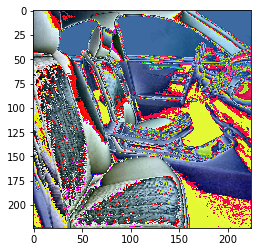

[ 0.]


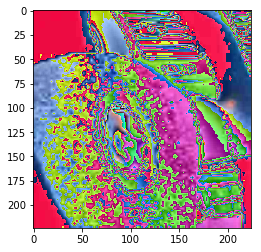

[ 0.]


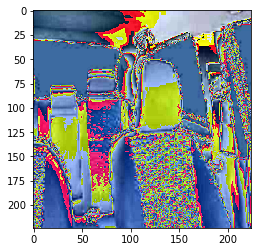

[ 0.]


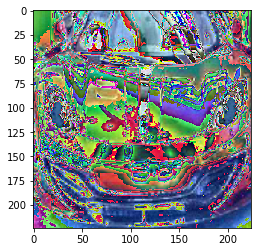

[ 1.]


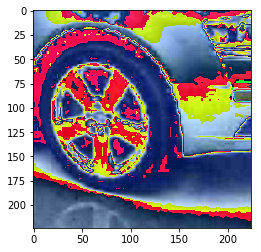

[ 1.]


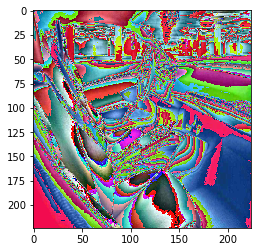

[ 0.]


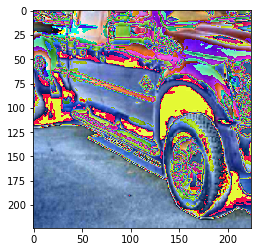

[ 1.]


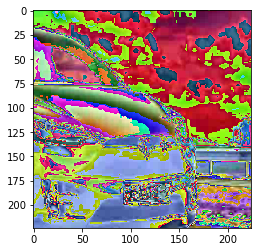

[ 0.]


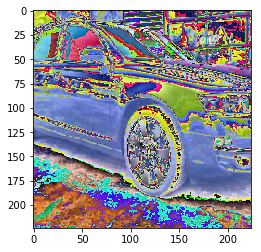

[ 1.]


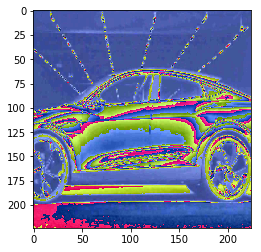

[ 1.]


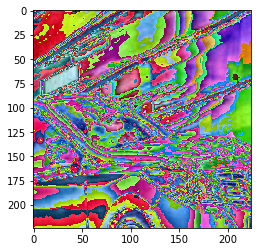

[ 1.]


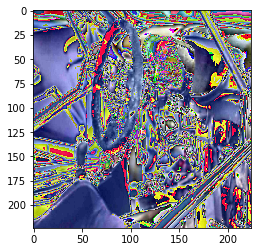

[ 0.]


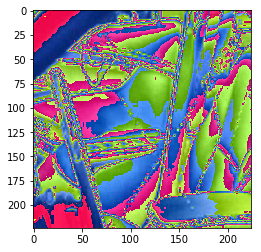

[ 0.]


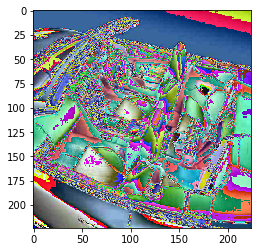

[ 0.]


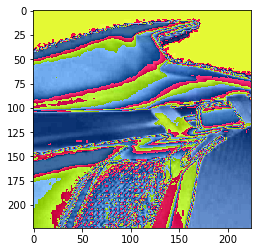

[ 0.]


[ 1.]


In [12]:
batch_x_train,batch_y_train = next(train_iterator)
show_images(batch_x_train,batch_y_train)

In [ ]:
##### debugging
train_data,train_label = next(train_iterator)

input_tensor = []
labels_tensor = []
for i in range (0,len(train_data)):

    input_tensor.append(totensor(train_data[i]))
    labels_tensor.append(totensor(train_label[i]).long())

input_tensor = torch.stack(input_tensor) 
labels_tensor = torch.stack(labels_tensor)
print(labels_tensor.size()[0])
labels_tensor = labels_tensor.view(labels_tensor.size()[0])

if use_gpu:
    inputs = Variable(input_tensor.cuda())
    labels = Variable(labels_tensor.cuda())
print(labels)

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.autograd.Variable(torch.randn(3, 5), requires_grad=True)
target = torch.autograd.Variable(torch.LongTensor(3,1).random_(5))
print(target.size()[0])
target = target.view(3)
pdb.set_trace()
output = loss(input, target)
output.backward()

### Training

In [23]:
def train_model_new(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
            
        for batch in tqdm(range(0, train_datasize//batch_size + 1)):
            
            train_data, train_label = next(train_iterator)
            input_tensor = []
            labels_tensor = []
            scheduler.step()
            model.train(True)
            for i in range (0,len(train_data)):
                
                input_tensor.append(totensor(train_data[i]))
                labels_tensor.append(totensor(train_label[i]).long())          
            
            input_tensor = torch.stack(input_tensor) 
            labels_tensor = torch.stack(labels_tensor)
            labels_tensor = labels_tensor.view(labels_tensor.size()[0]) # reshape from 16x1 to 16
  
            
            
            if use_gpu:
                inputs = Variable(input_tensor.cuda())
                labels = Variable(labels_tensor.cuda())
            else:
                inputs, labels = Variable(input_tensor), Variable(labels_tensor)

            running_loss = 0.0
            running_corrects = 0
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            pdb.set_trace() # debugging
            loss = criterion(outputs, labels)
            
            # backward + optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels)
            
        epoch_loss = running_loss / train_datasize
        epoch_acc = running_corrects / train_datasize
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': best_model_wts,
                'best_prec1': best_acc,
                'optimizer' : optimizer.state_dict(),
            })
        
        # epoch over validation
        for batch in tqdm(range(0, val_datasize//batch_size + 1)):
            
            running_loss = 0.0
            running_corrects = 0
            
            model.train(False)
            
            val_data, val_label = next(val_iterator)
            input_tensor = []
            labels_tensor = []
            
            for i in range (0,len(train_data)):
                input_tensor.append(totensor(val_data[i]))
                labels_tensor.append(totensor(val_label[i]).long())
                
            
            input_tensor = torch.stack(input_tensor) 
            labels_tensor = torch.stack(labels_tensor) 
            labels_tensor = labels_tensor.view(labels_tensor.size()[0])
            
            if use_gpu:
                inputs = Variable(input_tensor.cuda())
                labels = Variable(labels_tensor.cuda())
            else:
                inputs, labels = Variable(input_tensor), Variable(labels_tensor)
                
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels)
            
            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
        epoch_loss = running_loss / val_datasize
        epoch_acc = running_corrects / val_datasize
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('validation', epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
# load model from checkpoints
# model_path = WEIGHTS_PATH + '0.9955_model_best.pth.tar'
# model = torch.load(model_path)
# weights = model['state_dict']
# model_ft.load_state_dict(weights)

In [49]:
model_ft = models.vgg16(pretrained=True)

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.fc1 = nn.Linear(25088,4096)
        self.fc2 = nn.Linear(4096,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

model_ft.classifier = classifier()


use_gpu = torch.cuda.is_available()
if use_gpu:
    model_ft=model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/THC/generic/THCTensorCopy.c:18

In [ ]:
#Train and evaluate
model_ft = train_model_new(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

## Visualize model results and debug

In [9]:
# define model 
model_vgg16 = models.vgg16(pretrained=True)

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.fc1 = nn.Linear(25088,4096)
        self.fc2 = nn.Linear(4096,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(x)

model_vgg16.classifier = classifier()

# load model from disk

from six import iteritems
VGG_mean = [0.485, 0.456, 0.406]
VGG_std = [0.229, 0.224, 0.225]


weights_file = '/home/avinash/Documents/DeeplearningJs/resources/data/weights/no_cen_crop0.9955_model_best.pth.tar'

weights = torch.load(weights_file)['state_dict']

model_vgg16.load_state_dict(weights)


In [ ]:
# scrap code 

    ## matrix from deeplearnjs
    import json

    with open('/home/avinash/Desktop/incorr_img.json') as json_file:
        json_data = json.load(json_file)

    values = [i for i in json_data["data"].values()]
    values = np.array(values).astype("float32")
    img_matrix_deeplearnjs = values.reshape((224,224,3))
#     img_matrix_deeplearnjs = np.resize(img_matrix_deeplearnjs,(224,224,3))
    img = img_matrix_deeplearnjs.astype("uint8")
    inputs = img_matrix_deeplearnjs

In [14]:

def visualize_model_from_disk(model, img_path):
    '''
    inference from a pre trained model
    
    '''

    img = Image.open( img_path ).convert("RGB").resize((224, 224)) 
    
    img_array = np.asarray( img, dtype="float32" )
    
    inputs_norm = img_array/255.0
    inputs_mean_norm = np.subtract(inputs_norm,np.array(VGG_mean, dtype='float32'))
    inputs_std_norm = np.divide(inputs_mean_norm,np.array(VGG_std, dtype='float32'))
    
    inputs = inputs_std_norm.transpose((2,0,1))
    
    inputs = np.expand_dims(inputs, axis=0)

    inputs = torch.from_numpy(inputs)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        inputs = Variable(inputs.cuda())
    else:
        inputs  = Variable(inputs)

    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)

    plt.imshow(img)
    plt.show()
    
    print(class_names[preds[0]])
    print("last layer output",outputs.data)
    
#     # debugging
#     return outputs.data

#### Debugging
For array = np.ones((3,224,224), dtype="float32")

pytorch model output -1.9414 -0.1549

the deeplearnjs output 0.3803774118423462,0.8174245357513428.

##### Check the value of weights 

In [497]:
def verify_weights_values(weights):
    i = 0
    for (var_name, var_weights) in iteritems(weights):
        i+=1
        print(var_weights.size(), var_name)
    #     print(list(map(int, list(var_weights.size()))))

        tensor = var_weights.cpu().numpy()

        if len(tensor.shape) is 4:
            tensor = np.transpose(tensor,(2,3,1,0))
        else :
            tensor = np.transpose(tensor)

        print(tensor.shape)
        print(tensor.flatten()[0:10])


torch.Size([64, 3, 3, 3]) features.0.weight
(3, 3, 3, 64)
[-0.55299807  0.22965835  0.17691387  0.0665573   0.31113073 -0.09727886
 -0.41234365 -0.0605398  -0.31545234 -0.21608667]
torch.Size([64]) features.0.bias
(64,)
[ 0.4053956   0.37297153  0.46310529 -0.32333201  0.39771742 -0.39540169
  0.38827544 -0.54972744  0.26940992 -0.7604714 ]
torch.Size([64, 64, 3, 3]) features.2.weight
(3, 3, 64, 64)
[-0.03098117 -0.01354001  0.0129903  -0.11520031 -0.01817351 -0.03065846
 -0.0548223  -0.16471349  0.0622751  -0.03773636]
torch.Size([64]) features.2.bias
(64,)
[ 0.00098403 -0.09059093  0.6177063  -0.08204774  0.24562623 -0.04730402
  0.1315036  -0.02909383 -0.14466259  0.30690432]
torch.Size([128, 64, 3, 3]) features.5.weight
(3, 3, 64, 128)
[-0.0625846  -0.00085767  0.03322713 -0.02454278 -0.01626362  0.04780344
  0.02225716 -0.07551078  0.01893497 -0.00156153]
torch.Size([128]) features.5.bias
(128,)
[ 0.08695851 -0.01825795  0.13416353  0.02173696  0.06258877 -0.07486797
  0.03311652 

##### To get the output from a intermediate layer 

In [599]:
# Get output from the specified layer during inference.
# create a new model with only those layers from them we want to get the output. 

original_model = model_vgg16

class AlexNetConv4(nn.Module):
            def __init__(self):
                super(AlexNetConv4, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_model.features.children())
                )
                self.classifier = nn.Sequential(*list(original_model.classifier.children())[0:2])
            def forward(self, x):
                x = self.features(x)
                x = x.view(-1,25088)
                x= self.classifier(x)
                return x

model = AlexNetConv4()

#### predict for all images in a folder

In [ ]:
img_path = '/home/avinash/Desktop/temp/testing_data/'
filenames = os.walk(img_path)
for _,_,filenames in os.walk(img_path):
    for img in filenames:
        visualize_model_from_disk(model_vgg16, img_path + img)


In [47]:
test_transforms = {
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(input_img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

test_dir = '/home/avinash/Desktop/testing_Cars_images/'

test_datasets = {'test': datasets.ImageFolder(test_dir,test_transforms['val'])}
test_dataloders = {'test': torch.utils.data.DataLoader(test_datasets['test'], batch_size=4,
                                             shuffle=True, num_workers=4)}

def visualize_test_data(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(40,40))

    for i, data in enumerate(test_dataloders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return       

In [48]:
visualize_test_data(model_ft,20)

## ConvNet as fixed feature extractor

In [223]:
import json
file = {}
file['a'] = {'x':1, 'y':2}
with open('test.json', 'w') as f:
    f.write(json.dumps(file, indent=2, sort_keys=True))

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [224]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/avinash/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:03<00:00, 13446157.38it/s]


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [225]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0816 Acc: 0.8682
val Loss: 0.0239 Acc: 0.9732
writing best model

Epoch 1/24
----------
train Loss: 0.0864 Acc: 0.8752
val Loss: 0.0075 Acc: 0.9821
writing best model

Epoch 2/24
----------
train Loss: 0.0825 Acc: 0.8729
val Loss: 0.0112 Acc: 0.9821

Epoch 3/24
----------
train Loss: 0.0853 Acc: 0.8735
val Loss: 0.0061 Acc: 0.9911
writing best model

Epoch 4/24
----------
train Loss: 0.0963 Acc: 0.8519
val Loss: 0.0059 Acc: 0.9911

Epoch 5/24
----------
train Loss: 0.0832 Acc: 0.8636
val Loss: 0.0055 Acc: 0.9911

Epoch 6/24
----------
train Loss: 0.0815 Acc: 0.8694
val Loss: 0.0138 Acc: 0.9777

Epoch 7/24
----------
train Loss: 0.0584 Acc: 0.9125
val Loss: 0.0034 Acc: 1.0000
writing best model

Epoch 8/24
----------
train Loss: 0.0713 Acc: 0.8892
val Loss: 0.0054 Acc: 0.9911

Epoch 9/24
----------
train Loss: 0.0609 Acc: 0.9079
val Loss: 0.0046 Acc: 0.9911

Epoch 10/24
----------
train Loss: 0.0592 Acc: 0.9050
val Loss: 0.0072 Acc: 0.9911

Epoch 11/2

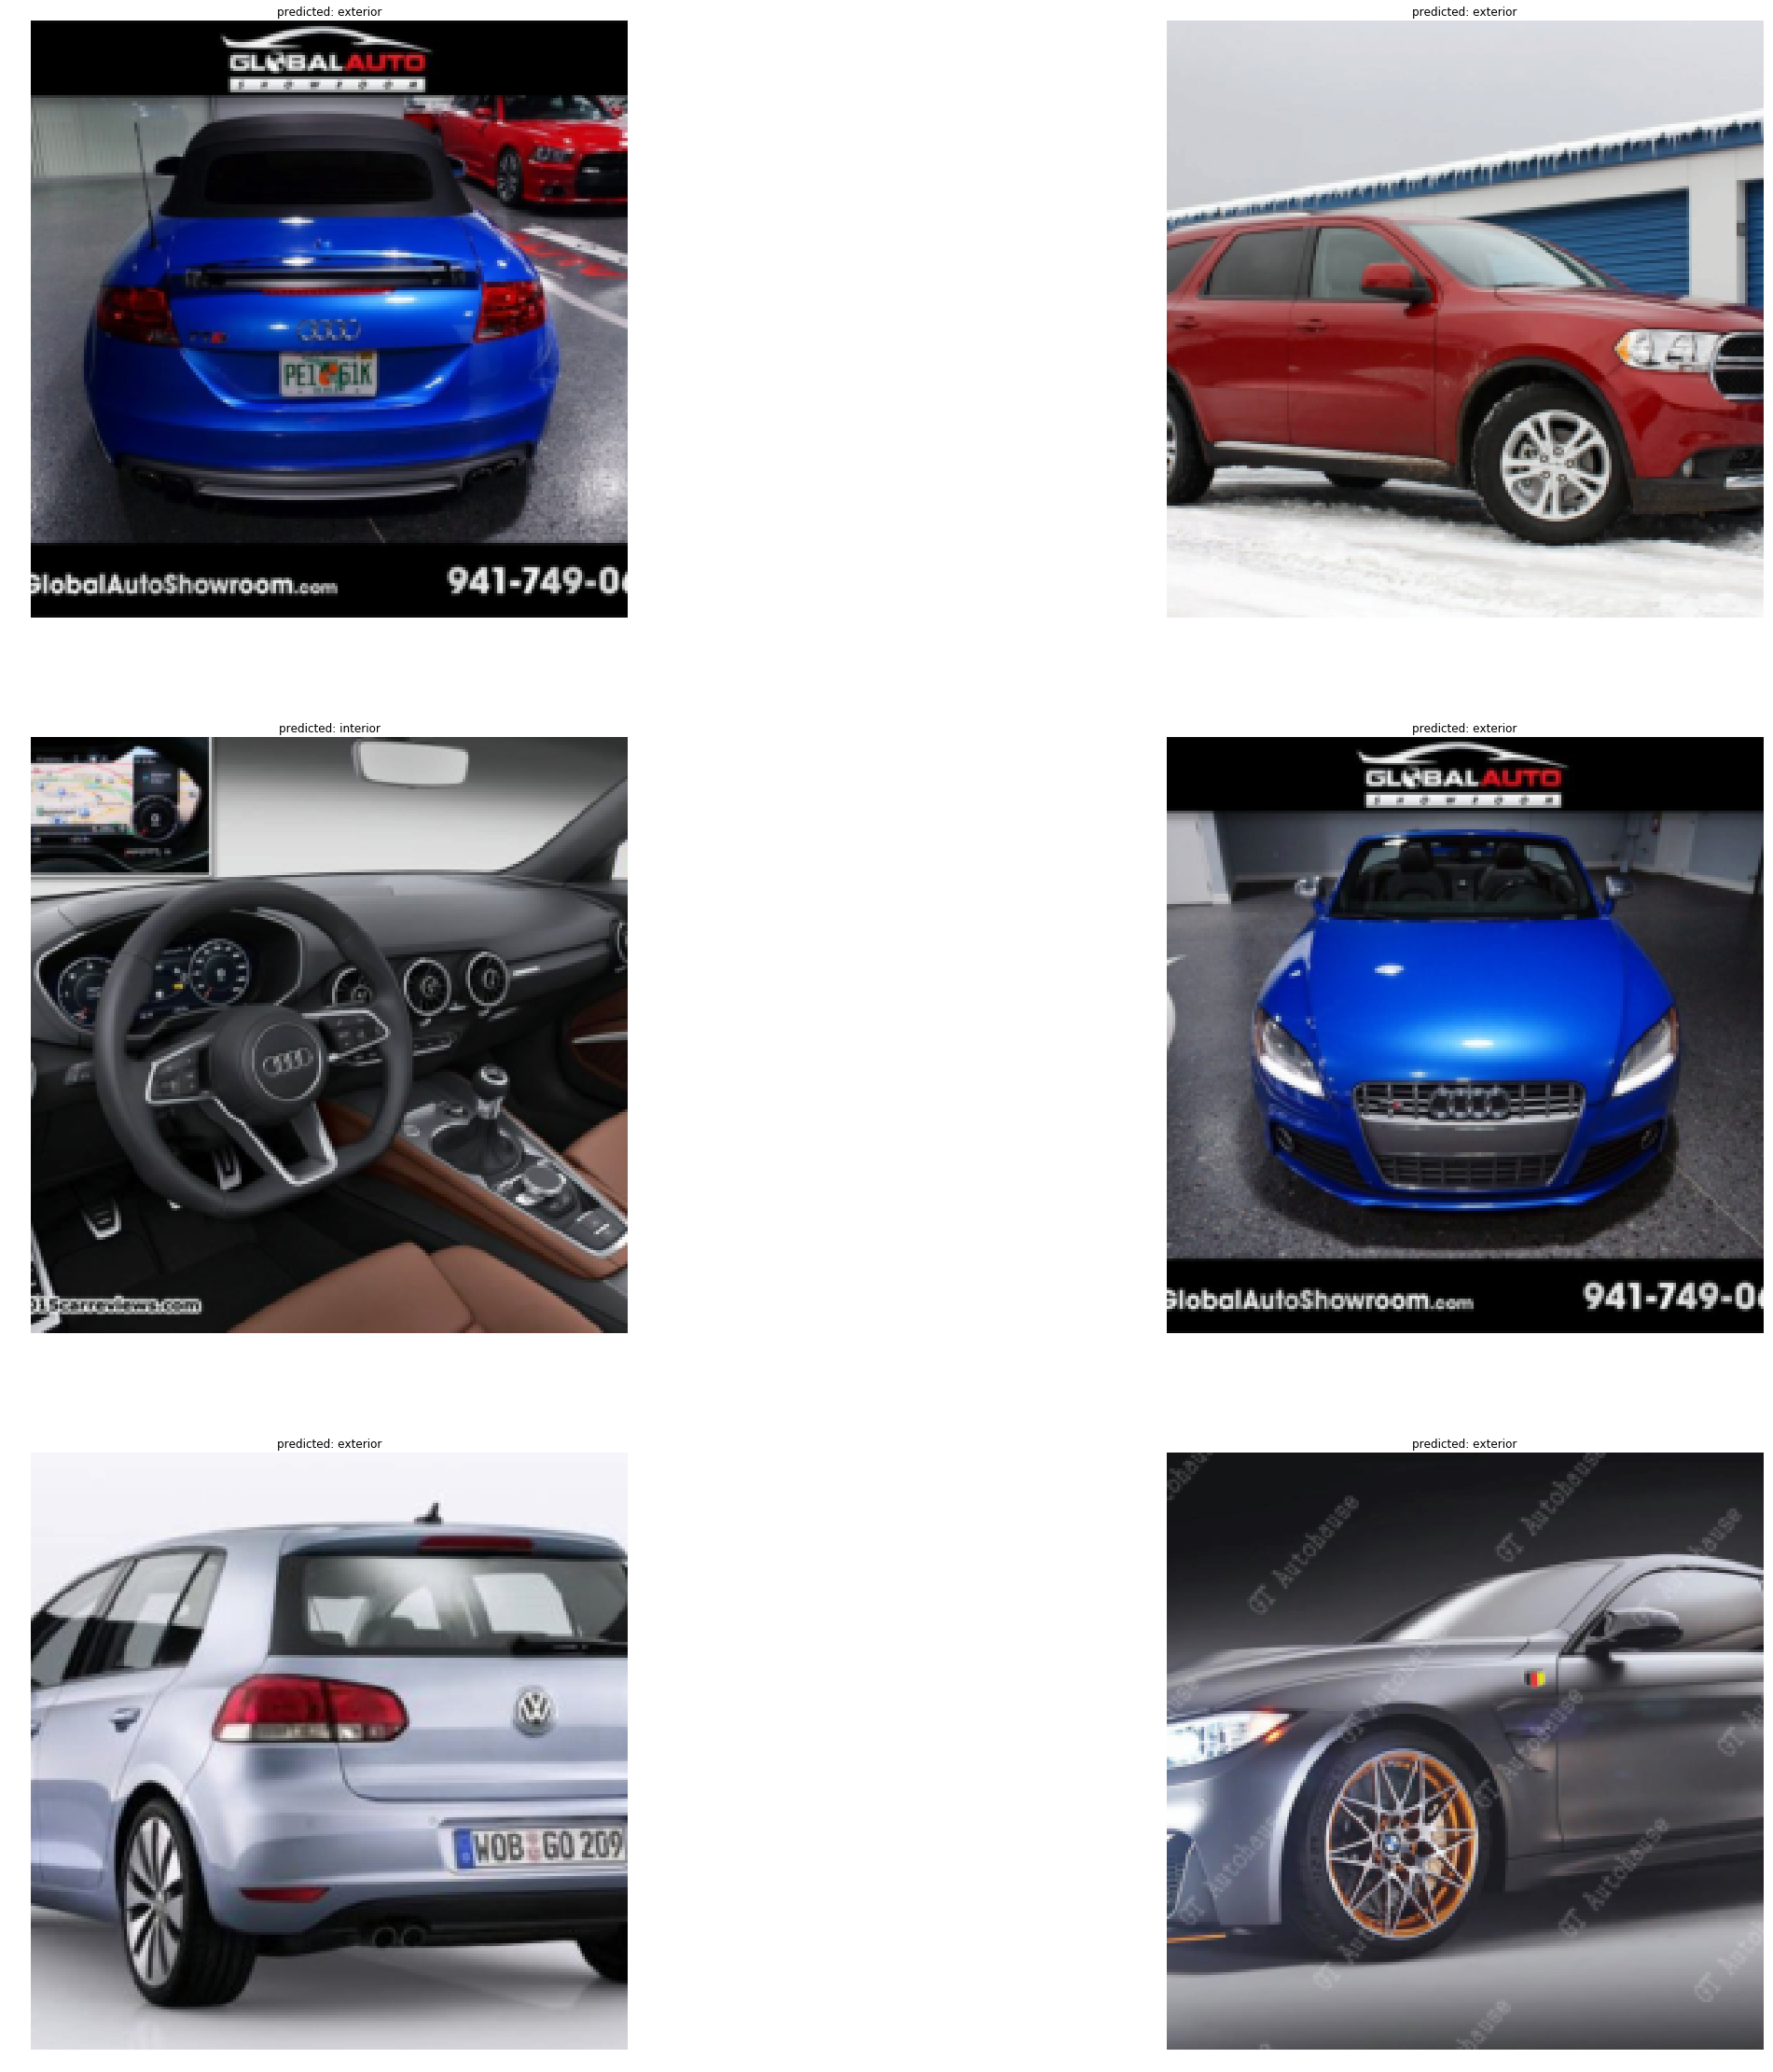

In [226]:
visualize_model(model_conv)

plt.ioff()
plt.show()